In [12]:
import time
import sqlite3
import os
import random
import numpy as np
import cupy as cp
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from PIL import Image
from scipy import interp
from itertools import cycle
from keras.models import Model, Input, load_model
from tensorflow.keras import datasets, layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_curve, auc


#  Data Processing

In [2]:
gear_defects = [0, 35, 76, 77]

In [3]:
# Image size
size = [300, 400]

In [4]:
# Load pre-processed dataset
X_train = np.load('gears_train_300x400_0,76,77,35.npy')
X_test = np.load('gears_test_300x400_0,76,77,35.npy')
y_train = np.load('gears_ytrain_300x400_0,76,77,35.npy')
y_test = np.load('gears_ytest_300x400_0,76,77,35.npy')

10.958188533782959


# Training 

In [5]:
# Set up architecture
dropout = 0.5
model = models.Sequential()
model.add(layers.Conv2D(64, (11, 11), strides=(4,4), activation='relu', input_shape=(size[0],size[1],1)))
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))
model.add(layers.Dropout(dropout))
model.add(layers.Conv2D(128, (5, 5), strides=(1,1), padding="same", activation='relu'))
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))
model.add(layers.Dropout(dropout))
model.add(layers.Conv2D(256, (3, 3), strides=(1,1), padding="same", activation='relu'))
model.add(layers.Conv2D(256, (3, 3), strides=(1,1), padding="same", activation='relu'))
model.add(layers.Conv2D(128, (3, 3), strides=(1,1), padding="same", activation='relu'))
model.add(layers.MaxPooling2D((3, 3), strides=(2,2)))
model.add(layers.Dropout(dropout))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(dropout))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(len(np.unique(y_train))))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 98, 64)        7808      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 48, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 48, 128)       204928    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 23, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 23, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 23, 256)       2

In [6]:
# Define early stopping and best model checkpoint
es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, min_delta=0.1, patience=40)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1, save_best_only=True)

In [7]:
# Fitting model with early stopping and checkpoint save
history = model.fit(X_train, y_train, epochs=100, 
                    validation_data=(X_test, y_test), callbacks=[es, mc])

Epoch 1/100
262/262 [==============================] - ETA: 0s - loss: 1.0507 - accuracy: 0.8599
Epoch 00001: val_accuracy improved from -inf to 0.79672, saving model to best_model.h5
262/262 [==============================] - 6s 24ms/step - loss: 1.0507 - accuracy: 0.8599 - val_loss: 0.4523 - val_accuracy: 0.7967
Epoch 2/100
262/262 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.9179
Epoch 00002: val_accuracy improved from 0.79672 to 0.88584, saving model to best_model.h5
262/262 [==============================] - 6s 22ms/step - loss: 0.2752 - accuracy: 0.9179 - val_loss: 0.4675 - val_accuracy: 0.8858
Epoch 3/100
262/262 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.9386
Epoch 00003: val_accuracy improved from 0.88584 to 0.94316, saving model to best_model.h5
262/262 [==============================] - 6s 22ms/step - loss: 0.2303 - accuracy: 0.9386 - val_loss: 0.2346 - val_accuracy: 0.9432
Epoch 4/100
262/262 [=========================

Epoch 29/100
262/262 [==============================] - ETA: 0s - loss: 0.0634 - accuracy: 0.9799
Epoch 00029: val_accuracy did not improve from 0.97929
262/262 [==============================] - 6s 21ms/step - loss: 0.0634 - accuracy: 0.9799 - val_loss: 0.0911 - val_accuracy: 0.9740
Epoch 30/100
262/262 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9774
Epoch 00030: val_accuracy did not improve from 0.97929
262/262 [==============================] - 6s 21ms/step - loss: 0.0797 - accuracy: 0.9774 - val_loss: 0.6857 - val_accuracy: 0.8704
Epoch 31/100
262/262 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.9791
Epoch 00031: val_accuracy did not improve from 0.97929
262/262 [==============================] - 6s 21ms/step - loss: 0.0612 - accuracy: 0.9791 - val_loss: 0.1256 - val_accuracy: 0.9754
Epoch 32/100
262/262 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9847
Epoch 00032: val_accuracy did not improve from 

In [118]:
# Load the best model
model.load_weights('best_model.h5')

In [134]:
model.save("alexnet.h5")

In [ ]:
# Convert the history.history dict to a pandas DataFrame
hist_df = pd.DataFrame(history.history) 

# Save to json for plots 
hist_json_file = 'alexnet_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# Metrics

In [14]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

65/65 - 1s - loss: 0.0426 - accuracy: 0.9889

Test accuracy: 0.9889209866523743


In [15]:
# Show metrics
predictions = model.predict(X_test)
y_pred = predictions.argmax(axis=1).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       166
           1       0.99      0.99      0.99       198
           2       1.00      0.99      0.99      1558
           3       0.98      1.00      0.99       154

    accuracy                           0.99      2076
   macro avg       0.97      0.99      0.98      2076
weighted avg       0.99      0.99      0.99      2076



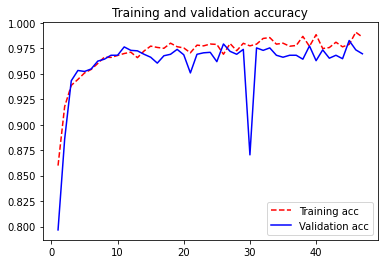

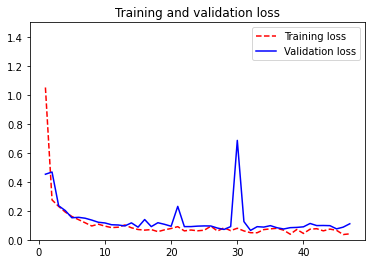

In [16]:
# Plot train and test validation of loss values and accuracy values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'r--', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim([0,1.5])
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
# ROC binary label reshaping
y_pred_roc = (y_pred[:,None] == np.arange(y_pred.max()+1)).astype(int)
y_test_roc = (y_test[:,None] == np.arange(y_test.max()+1)).astype(int)

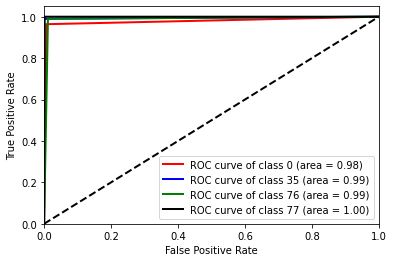

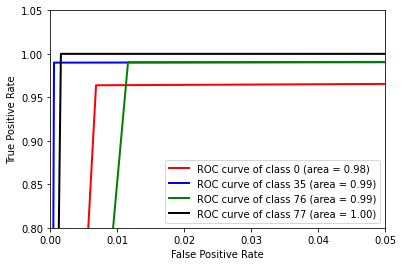

In [91]:
# Plot ROC
def plot_roc(y_test, y_pred):
    # Plot linewidth.
    lw = 2
    n_classes = len(y_pred_roc[0])
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_roc[:, i], y_pred_roc[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # Plot all ROC curves
    plt.figure(1)

    colors = cycle(['red', 'blue', 'green', 'black'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class '+str(gear_defects[i])+' (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig('ROC')
    plt.show()
    
    # Zoom in view of the upper left corner.
    plt.figure(2)
    plt.xlim(0, 0.05)
    plt.ylim(0.8, 1.05)
    colors = cycle(['red', 'blue', 'green', 'black'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class '+str(gear_defects[i])+' (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig('ROC_zoom')
    plt.show()
    
plot_roc(y_test_roc,y_pred_roc)

<AxesSubplot:>

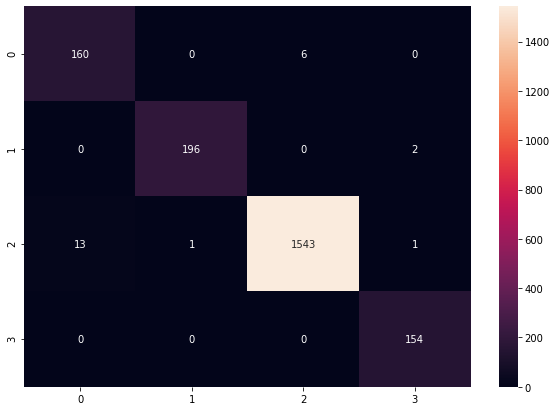

In [36]:
matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(matrix, index = [i for i in range(len(np.unique(y_test)))],
                  columns = [i for i in range(len(np.unique(y_test)))])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt='g')